In [3]:
# Importing important libraries
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings("ignore")


Number of training images: 6225
Number of validation images: 1092
Number of test images: 3187
Number of classes: 11
Class names: ['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']


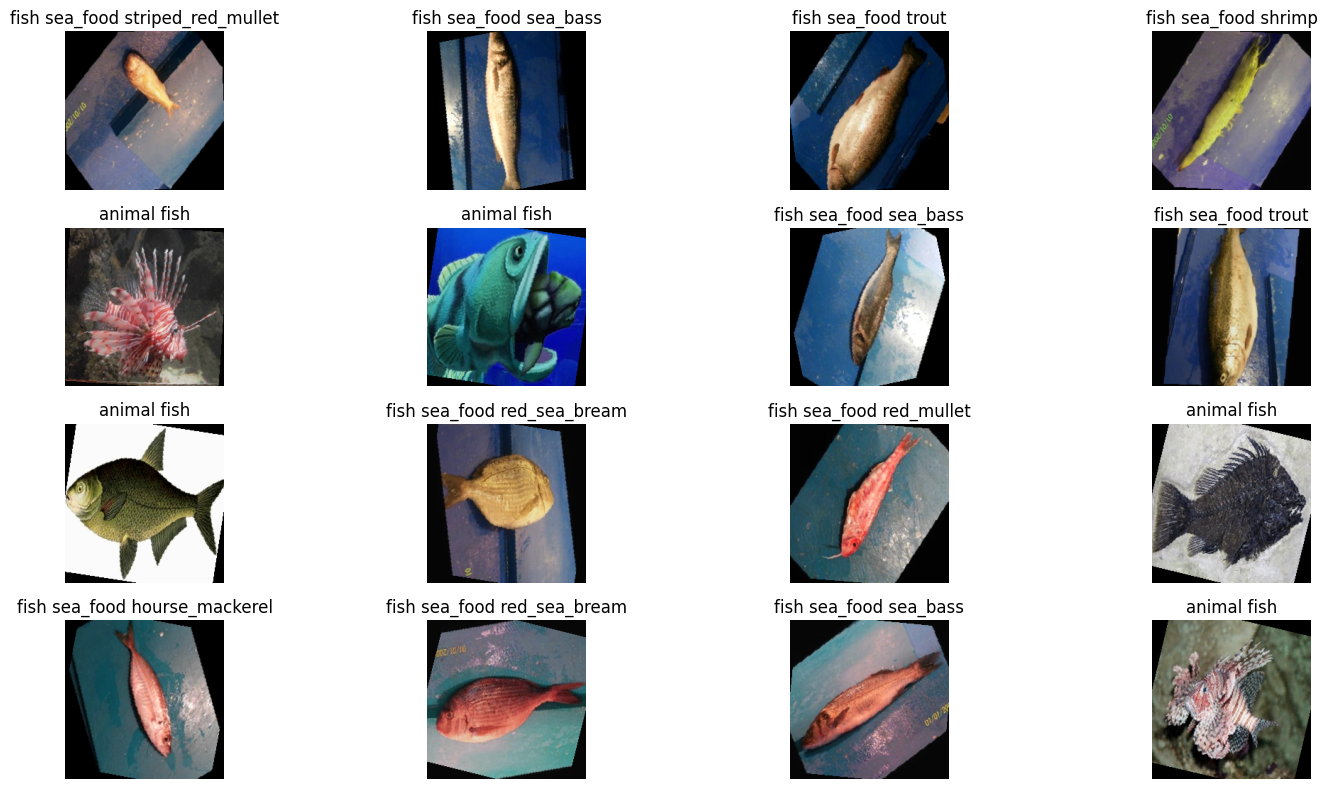

In [4]:
# Define path to dataset
data_dir = "E:/vscode/Fish Classification Project/images.cv_jzk6llhf18tm3k0kyttxz/data"
train_dir = f"{data_dir}/train"
test_dir = f"{data_dir}/test"
val_dir = f"{data_dir}/val"

# Define transformations for training data (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to standard size
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(15),  # Data augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Data augmentation
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Define transformations for validation and test data (no augmentation)
eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=eval_transforms)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=eval_transforms)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Get class names
class_names = train_dataset.classes
num_classes = len(class_names)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

# Visualize some sample images from the training set
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Unnormalize
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    return img

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images
plt.figure(figsize=(16, 8))
for i in range(min(16, batch_size)):
    plt.subplot(4, 4, i+1)
    plt.imshow(imshow(images[i]))
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
# Custom CNN Architecture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy

class FishCNN(nn.Module):
    def __init__(self, num_classes):
        """
        Custom CNN architecture for fish classification
        
        Args:
            num_classes (int): Number of fish categories to classify
        """
        super(FishCNN, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fourth convolutional block
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Calculate the size after convolutions and pooling
        # Starting with 224x224 and applying 4 pooling layers with stride 2
        # Each MaxPool2d with stride=2 reduces dimensions by half:
        # 224 -> 112 -> 56 -> 28 -> 14
        flattened_size = 256 * 14 * 14
        
        # Fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        """Forward pass through the network"""
        # First block
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        
        # Second block
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        
        # Third block
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        
        # Fourth block
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = self.fc2(x)
        
        return x

In [6]:
# Initialize the model
def initialize_model(num_classes):
    """Initialize and return the FishCNN model"""
    model = FishCNN(num_classes)
    return model

In [7]:
# Training function
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25):
    """
    Train the model
    
    Args:
        model: The neural network model
        dataloaders: Dictionary with 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimization algorithm
        device: Device to run the training on (cuda or cpu)
        num_epochs: Number of epochs to train
        
    Returns:
        model: Trained model with best weights
        history: Dictionary containing training history
    """
    since = time.time()
    
    # Save training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Store best model weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                # Track history only in train phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
            
            # Deep copy the model if best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [8]:
# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    """
    Evaluate the model on the test set
    
    Args:
        model: The trained neural network model
        dataloader: Dataloader for the test set
        criterion: Loss function
        device: Device to run the evaluation on (cuda or cpu)
        
    Returns:
        test_loss: Loss on the test set
        test_acc: Accuracy on the test set
        all_preds: All predictions made by the model
        all_labels: All true labels
    """
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

In [9]:
# Function to plot training history
def plot_training_history(history):
    """
    Plot the training and validation loss and accuracy
    
    Args:
        history: Dictionary containing training history
    """
    plt.figure(figsize=(12, 4))
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Using device: cpu
Epoch 1/20
----------
train Loss: 3.0726 Acc: 0.3055
val Loss: 1.3118 Acc: 0.5137

Epoch 2/20
----------
train Loss: 1.4992 Acc: 0.4442
val Loss: 1.0622 Acc: 0.6026

Epoch 3/20
----------
train Loss: 1.3805 Acc: 0.4816
val Loss: 0.9194 Acc: 0.7161

Epoch 4/20
----------
train Loss: 1.2921 Acc: 0.5197
val Loss: 0.8052 Acc: 0.7427

Epoch 5/20
----------
train Loss: 1.2240 Acc: 0.5460
val Loss: 0.7933 Acc: 0.7555

Epoch 6/20
----------
train Loss: 1.1554 Acc: 0.5680
val Loss: 0.7381 Acc: 0.7784

Epoch 7/20
----------
train Loss: 1.0950 Acc: 0.5904
val Loss: 0.6679 Acc: 0.7619

Epoch 8/20
----------
train Loss: 1.0784 Acc: 0.6061
val Loss: 0.6561 Acc: 0.7839

Epoch 9/20
----------
train Loss: 0.9844 Acc: 0.6358
val Loss: 0.6203 Acc: 0.8233

Epoch 10/20
----------
train Loss: 0.9411 Acc: 0.6488
val Loss: 0.4738 Acc: 0.8672

Epoch 11/20
----------
train Loss: 0.9001 Acc: 0.6654
val Loss: 0.5335 Acc: 0.8333

Epoch 12/20
----------
train Loss: 0.8656 Acc: 0.6813
val Loss: 0.3

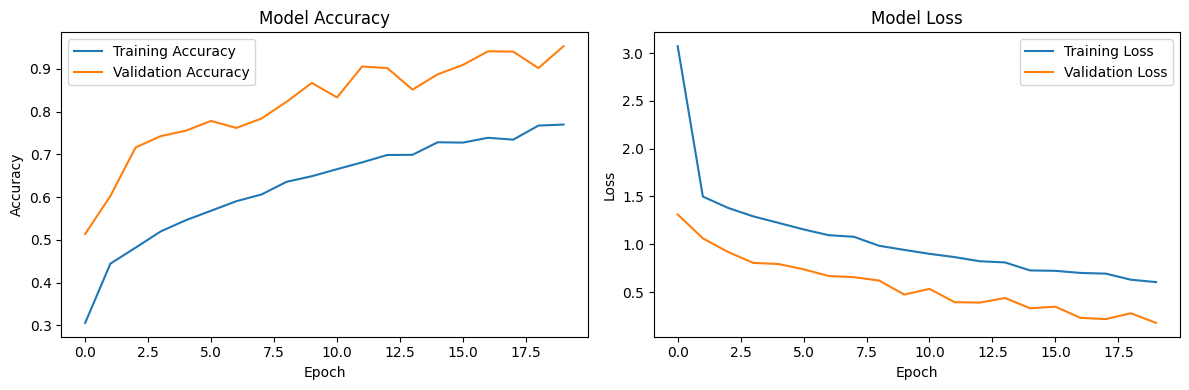

Test Loss: 0.1774 Acc: 0.9451

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.99      0.99      0.99       298
   fish sea_food gilt_head_bream       0.80      0.95      0.87       305
   fish sea_food hourse_mackerel       0.96      1.00      0.98       286
        fish sea_food red_mullet       0.90      1.00      0.94       291
     fish sea_food red_sea_bream       0.97      0.96      0.97       273
          fish sea_food sea_bass       1.00      0.72      0.83       327
            fish sea_food shrimp       1.00      0.95      0.97       289
fish sea_food striped_red_mullet       0.91      0.92      0.92       293
             fish sea_food trout       0.99      1.00      1.00       292

                        accuracy                        

e:\vscode\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\vscode\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\vscode\.venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


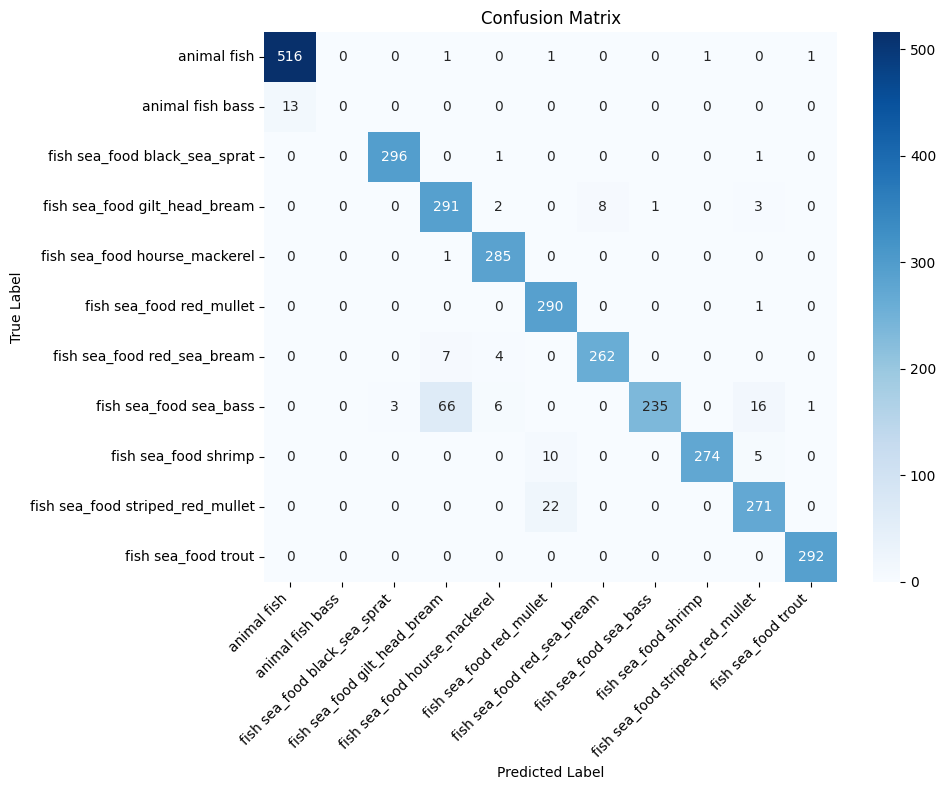

Model saved to fish_cnn_model.pth


In [12]:
# Set up device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss function, and optimizer
model = initialize_model(num_classes)
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare dataloaders dictionary
dataloaders = {
    'train': train_loader,
    'val': val_loader
}

# Train the model
num_epochs = 20
model, history = train_model(
    model=model,
    dataloaders=dataloaders,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

# Plot training history
plot_training_history(history)

# Evaluate the model on test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(
    model=model,
    dataloader=test_loader,
    criterion=criterion,
    device=device
)

# Display detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Save the trained model
model_save_path = 'fish_cnn_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'class_names': class_names,
    'num_classes': num_classes
}, model_save_path)

print(f"Model saved to {model_save_path}")

In [11]:
# Function to convert PyTorch .pth models to .pkl format
import pickle
import os

def convert_pth_to_pkl(pth_path, include_full_model=False):
    """
    Convert a .pth model file to .pkl format
    
    Args:
        pth_path (str): Path to the .pth model file
        include_full_model (bool): Whether to include the full model architecture
                                  (requires model class definition)
    
    Returns:
        str: Path to the new .pkl file
    """
    # Load the .pth file
    checkpoint = torch.load(pth_path, map_location=torch.device('cpu'))
    
    # Create output path
    pkl_path = os.path.splitext(pth_path)[0] + '.pkl'
    
    # If include_full_model is True and we have the model class definition,
    # we can include the full model architecture
    if include_full_model:
        # This requires model class to be available
        model = initialize_model(checkpoint['num_classes'])
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Add the full model to the checkpoint
        checkpoint['model'] = model
    
    # Save as pickle
    with open(pkl_path, 'wb') as f:
        pickle.dump(checkpoint, f)
    
    print(f"Converted {pth_path} to {pkl_path}")
    return pkl_path

# Convert the model we've already saved
pth_model_path = 'fish_cnn_model.pth'
pkl_model_path = convert_pth_to_pkl(pth_model_path)

# If you want to include the full model architecture (recommended for better portability)
# Note: This requires that the initialize_model function and model class are defined
pkl_full_model_path = convert_pth_to_pkl(pth_model_path, include_full_model=True)

Converted fish_cnn_model.pth to fish_cnn_model.pkl
Converted fish_cnn_model.pth to fish_cnn_model.pkl


In [12]:
# Load the converted model
def load_pkl_model(pkl_path):
    """
    Load a model from a .pkl file
    
    Args:
        pkl_path (str): Path to the .pkl model file
        
    Returns:
        tuple: (model, class_names) or just the checkpoint dictionary
    """
    with open(pkl_path, 'rb') as f:
        checkpoint = pickle.load(f)
    
    # If the full model was saved
    if 'model' in checkpoint:
        model = checkpoint['model']
        class_names = checkpoint['class_names']
        return model, class_names
    else:
        # If only state_dict was saved
        print("Only state dictionaries found. You'll need to initialize the model first.")
        return checkpoint

# Example usage:
# model, class_names = load_pkl_model('fish_cnn_model.pkl')
# OR
# checkpoint = load_pkl_model('fish_cnn_model.pkl')
# model = initialize_model(checkpoint['num_classes'])
# model.load_state_dict(checkpoint['model_state_dict'])

## Transfer Learning Implementation with Advanced Techniques

### 1. Enhanced Data Augmentation

In [13]:
# Enhanced Data Augmentation
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision

# Define the enhanced data augmentation for training
def get_enhanced_data_loaders(data_dir, batch_size=32, num_workers=4):
    """
    Create data loaders with enhanced augmentation techniques
    
    Args:
        data_dir (str): Path to the dataset directory
        batch_size (int): Batch size for training
        num_workers (int): Number of workers for data loading
        
    Returns:
        dict: Dictionary containing dataloaders and class names
    """
    train_dir = f"{data_dir}/train"
    val_dir = f"{data_dir}/val"
    test_dir = f"{data_dir}/test"
    
    # Enhanced data augmentation for training
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Standard transforms for validation and testing
    eval_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transforms)
    val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=eval_transforms)
    test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=eval_transforms)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    # Get class names and number of classes
    class_names = train_dataset.classes
    num_classes = len(class_names)
    
    print(f"Number of training images: {len(train_dataset)}")
    print(f"Number of validation images: {len(val_dataset)}")
    print(f"Number of test images: {len(test_dataset)}")
    print(f"Number of classes: {num_classes}")
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader,
        'class_names': class_names,
        'num_classes': num_classes
    }

### 2. Model Setup Functions

In [23]:
# Model Setup Functions
import torch
import torch.nn as nn
import torchvision.models as models
import timm

def setup_vgg16(num_classes, feature_extract=True):
    """Set up VGG16 model for transfer learning"""
    model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
    
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final classifier layers
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    
    return model

def setup_resnet152(num_classes, feature_extract=True):
    """Set up ResNet152 model for transfer learning"""
    model = models.resnet152(weights=models.ResNet152_Weights.DEFAULT)
    
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final fully connected layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    
    return model

def setup_convnext(num_classes, feature_extract=True):
    """Set up ConvNeXt model for transfer learning"""
    # Using ConvNeXt Base model
    model = timm.create_model('convnext_base', pretrained=True)
    
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final classifier head
    num_features = model.head.fc.in_features
    model.head.fc = nn.Linear(num_features, num_classes)
    
    return model

def setup_efficientnetv2(num_classes, feature_extract=True):
    """Set up EfficientNetV2 model for transfer learning"""
    model = models.efficientnet_v2_s(weights=models.EfficientNet_V2_S_Weights.DEFAULT)
    
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final classifier
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    
    return model

def setup_vit(num_classes, feature_extract=True):
    """Set up Vision Transformer model for transfer learning"""
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final head
    model.head = nn.Linear(model.head.in_features, num_classes)
    
    return model

def get_model(model_name, num_classes, feature_extract=True):
    """
    Get a pre-trained model based on the model name
    
    Args:
        model_name (str): Name of the model to use
        num_classes (int): Number of classes for the output layer
        feature_extract (bool): If True, only update the final layer params
        
    Returns:
        model: The initialized model
    """
    if model_name == "vgg16":
        return setup_vgg16(num_classes, feature_extract)
    elif model_name == "resnet152":
        return setup_resnet152(num_classes, feature_extract)
    elif model_name == "convnext":
        return setup_convnext(num_classes, feature_extract)
    elif model_name == "efficientnetv2":
        return setup_efficientnetv2(num_classes, feature_extract)
    elif model_name == "vit":
        return setup_vit(num_classes, feature_extract)
    else:
        raise ValueError(f"Unsupported model: {model_name}")

In [25]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    
    Args:
        patience (int): How many epochs to wait after last improvement
        min_delta (float): Minimum change to qualify as improvement
        verbose (bool): Whether to print messages
    """
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        score = -val_loss  # Higher score is better
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

### 3. Learning Rate Scheduler and Mixed Precision Training

In [26]:
# Learning Rate Scheduler and Training with Mixed Precision with Early Stopping
import torch
import torch.nn as nn
import torch.optim as optim
import time
import copy
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR

class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve.
    
    Args:
        patience (int): How many epochs to wait after last improvement
        min_delta (float): Minimum change to qualify as improvement
        verbose (bool): Whether to print messages
    """
    def __init__(self, patience=5, min_delta=0, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, val_loss, model):
        score = -val_loss  # Higher score is better
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def train_model_with_scheduler(model, dataloaders, criterion, optimizer, device, model_name,
                              num_epochs=10, use_amp=True, patience=5):
    """
    Train a model with learning rate scheduling, mixed precision, and early stopping
    
    Args:
        model: PyTorch model
        dataloaders: Dictionary with 'train' and 'val' dataloaders
        criterion: Loss function
        optimizer: Optimizer
        device: Device to train on
        model_name: Name of the model (for logging)
        num_epochs: Number of epochs to train
        use_amp: Whether to use automatic mixed precision
        patience: Number of epochs to wait before early stopping
        
    Returns:
        model: Best model based on validation accuracy
        history: Training history
    """
    since = time.time()
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler() if use_amp else None
    
    # Initialize learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Initialize early stopping
    early_stopping = EarlyStopping(patience=patience)
    
    # Initialize history dictionary
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    if use_amp and phase == 'train':
                        # Mixed precision training
                        with autocast():
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                        
                        # Get predictions
                        _, preds = torch.max(outputs, 1)
                        
                        # Backward + optimize with gradient scaling
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        # Regular training/validation
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['lr'].append(scheduler.get_last_lr()[0])
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Deep copy the model if best accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                
                # Check early stopping
                early_stopping(epoch_loss, model)
        
        # Step the scheduler after each epoch
        if phase == 'train':
            scheduler.step()
        
        # Check if early stopping should be triggered
        if early_stopping.early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### 4. Evaluation Function

In [18]:
# Model Evaluation
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, criterion, device, class_names):
    """
    Evaluate model on a dataset
    
    Args:
        model: PyTorch model
        dataloader: Dataloader for evaluation
        criterion: Loss function
        device: Device to evaluate on
        class_names: List of class names
        
    Returns:
        dict: Dictionary with evaluation metrics
    """
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    test_loss = running_loss / len(dataloader.dataset)
    test_acc = running_corrects.double() / len(dataloader.dataset)
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    # Classification report
    report = classification_report(all_labels, all_preds, 
                                  target_names=class_names, 
                                  output_dict=True)
    
    # Print detailed report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'loss': test_loss,
        'accuracy': test_acc.item(),
        'predictions': all_preds,
        'true_labels': all_labels,
        'classification_report': report,
        'confusion_matrix': cm
    }

### 5. Visualization Functions

In [19]:
# Visualization Functions
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_training_history(history, title):
    """
    Plot training history including loss, accuracy, and learning rate
    
    Args:
        history: Dictionary containing training history
        title: Plot title
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot training and validation accuracy
    axes[0].plot(history['train_acc'], label='Training Accuracy')
    axes[0].plot(history['val_acc'], label='Validation Accuracy')
    axes[0].set_title(f'{title} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    
    # Plot training and validation loss
    axes[1].plot(history['train_loss'], label='Training Loss')
    axes[1].plot(history['val_loss'], label='Validation Loss')
    axes[1].set_title(f'{title} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    
    # Plot learning rate
    if 'lr' in history:
        axes[2].plot(history['lr'])
        axes[2].set_title(f'{title} - Learning Rate')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Learning Rate')
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    """
    Plot confusion matrix
    
    Args:
        cm: Confusion matrix
        class_names: List of class names
        title: Plot title
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_model_comparison(results):
    """
    Plot comparison of model metrics
    
    Args:
        results: Dictionary with model results
    """
    models = list(results.keys())
    accuracies = [results[model]['metrics']['accuracy'] for model in models]
    
    # Create dataframe for plotting
    df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies
    })
    
    # Sort by accuracy
    df = df.sort_values('Accuracy', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Model', y='Accuracy', data=df)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    # Add text labels
    for i, v in enumerate(df['Accuracy']):
        ax.text(i, v + 0.01, f"{v:.4f}", ha='center')
    
    plt.tight_layout()
    plt.show()
    
    return df

### 6. Model Saving Functions

In [20]:
# Model Saving Functions
import pickle
import os

def save_model_pkl(model, model_name, optimizer, class_names, history, metrics):
    """
    Save model to pkl file
    
    Args:
        model: PyTorch model
        model_name: Name of the model
        optimizer: Optimizer
        class_names: List of class names
        history: Training history
        metrics: Evaluation metrics
        
    Returns:
        str: Path to saved model
    """
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Create file path
    file_path = f"models/{model_name}_model.pkl"
    
    # Save model and related information
    with open(file_path, 'wb') as f:
        pickle.dump({
            'model': model,
            'model_name': model_name,
            'optimizer': optimizer,
            'class_names': class_names,
            'num_classes': len(class_names),
            'history': history,
            'metrics': metrics
        }, f)
    
    print(f"Model saved to {file_path}")
    return file_path

def load_model_pkl(file_path):
    """
    Load model from pkl file
    
    Args:
        file_path: Path to model file
        
    Returns:
        dict: Dictionary with model and related information
    """
    with open(file_path, 'rb') as f:
        checkpoint = pickle.load(f)
    
    print(f"Model loaded from {file_path}")
    return checkpoint

### 7. Ensemble Methods

In [21]:
# Ensemble Methods
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

def ensemble_predict(models, dataloader, device, method='voting'):
    """
    Generate ensemble predictions from multiple models
    
    Args:
        models: List of trained models
        dataloader: Dataloader for prediction
        device: Device for computation
        method: Ensemble method ('voting' or 'averaging')
        
    Returns:
        tuple: (predictions, true_labels)
    """
    all_preds = []
    all_probs = []
    true_labels = []
    
    # Set all models to evaluation mode
    for model in models:
        model.eval()
    
    # No gradients needed for prediction
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            
            # Collect predictions from each model
            batch_preds = []
            batch_probs = []
            
            for model in models:
                outputs = model(inputs)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                _, preds = torch.max(outputs, 1)
                
                batch_preds.append(preds.cpu().numpy())
                batch_probs.append(probs.cpu().numpy())
            
            # Store predictions and labels
            all_preds.append(np.array(batch_preds))
            all_probs.append(np.array(batch_probs))
            true_labels.extend(labels.cpu().numpy())
    
    # Convert to arrays
    all_preds = np.concatenate(all_preds, axis=1)  # Shape: (num_models, num_samples)
    all_probs = np.concatenate(all_probs, axis=1)  # Shape: (num_models, num_samples, num_classes)
    
    # Generate ensemble predictions
    if method == 'voting':
        # Majority voting
        final_preds = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=0, 
            arr=all_preds
        )
    elif method == 'averaging':
        # Average probabilities
        avg_probs = np.mean(all_probs, axis=0)  # Shape: (num_samples, num_classes)
        final_preds = np.argmax(avg_probs, axis=1)
    else:
        raise ValueError(f"Unsupported ensemble method: {method}")
    
    return final_preds, true_labels

def evaluate_ensemble(models, dataloader, device, class_names, methods=['voting', 'averaging']):
    """
    Evaluate ensemble models
    
    Args:
        models: List of trained models
        dataloader: Dataloader for evaluation
        device: Device for computation
        class_names: List of class names
        methods: List of ensemble methods to evaluate
        
    Returns:
        dict: Evaluation results for each method
    """
    results = {}
    
    for method in methods:
        print(f"\nEvaluating ensemble with {method} method...")
        
        # Get predictions
        predictions, true_labels = ensemble_predict(
            models=models,
            dataloader=dataloader,
            device=device,
            method=method
        )
        
        # Calculate accuracy
        accuracy = accuracy_score(true_labels, predictions)
        print(f"Ensemble Accuracy ({method}): {accuracy:.4f}")
        
        # Classification report
        report = classification_report(
            true_labels, predictions, 
            target_names=class_names, 
            output_dict=True
        )
        
        print("\nClassification Report:")
        print(classification_report(true_labels, predictions, target_names=class_names))
        
        # Confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        
        # Store results
        results[method] = {
            'accuracy': accuracy,
            'predictions': predictions,
            'true_labels': true_labels,
            'classification_report': report,
            'confusion_matrix': cm
        }
        
        # Plot confusion matrix
        plot_confusion_matrix(
            cm=cm,
            class_names=class_names,
            title=f"Ensemble ({method}) Confusion Matrix"
        )
    
    return results

### 8. Complete Pipeline

Using device: cpu
Number of training images: 6225
Number of validation images: 1092
Number of test images: 3187
Number of classes: 11

==================== Training vgg16 ====================
Epoch 1/15
----------
train Loss: 1.1259 Acc: 0.6251
val Loss: 0.3759 Acc: 0.8700

Epoch 2/15
----------
train Loss: 0.9023 Acc: 0.6964
val Loss: 0.2842 Acc: 0.9075

Epoch 3/15
----------
train Loss: 0.8536 Acc: 0.7073
val Loss: 0.2475 Acc: 0.9167

Epoch 4/15
----------
train Loss: 0.8643 Acc: 0.7071
val Loss: 0.3019 Acc: 0.8828
EarlyStopping counter: 1 out of 5

Epoch 5/15
----------
train Loss: 0.8133 Acc: 0.7279
val Loss: 0.2296 Acc: 0.9203

Epoch 6/15
----------
train Loss: 0.8406 Acc: 0.7229
val Loss: 0.2073 Acc: 0.9231

Epoch 7/15
----------
train Loss: 0.8304 Acc: 0.7178
val Loss: 0.1881 Acc: 0.9258

Epoch 8/15
----------
train Loss: 0.8598 Acc: 0.7165
val Loss: 0.2291 Acc: 0.9194
EarlyStopping counter: 1 out of 5

Epoch 9/15
----------
train Loss: 0.8136 Acc: 0.7259
val Loss: 0.2153 Acc: 0

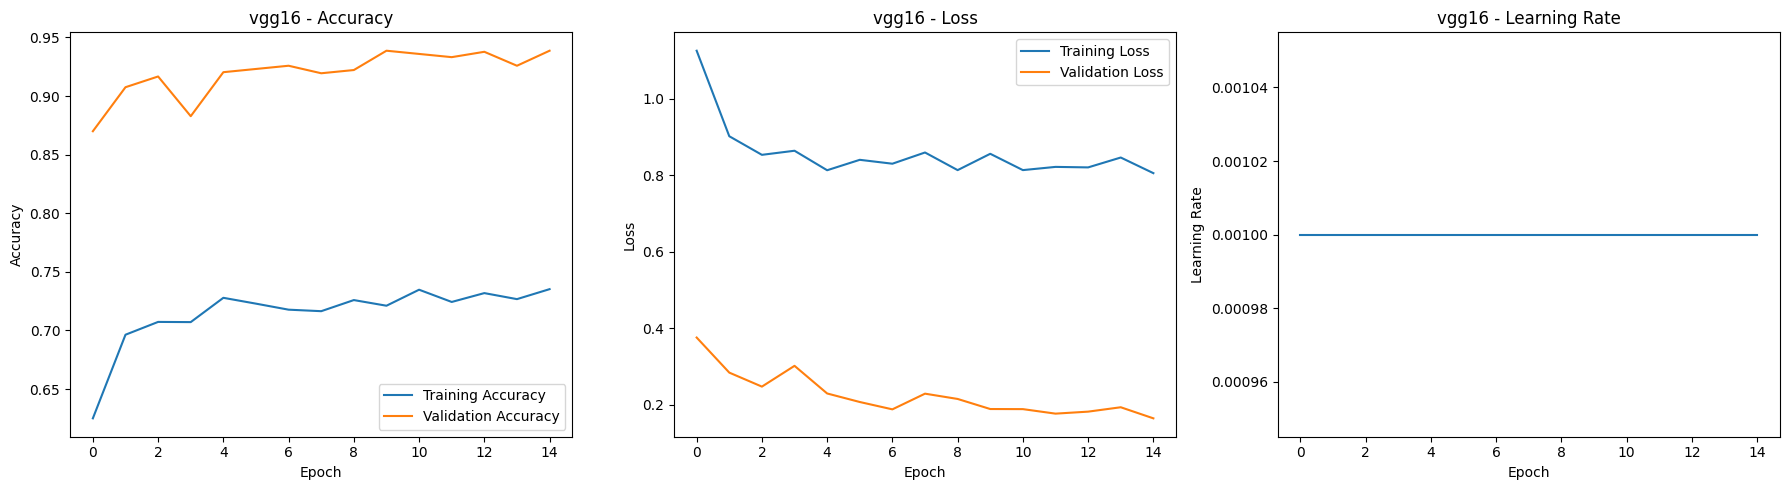

Test Loss: 0.1754 Acc: 0.9394

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       1.00      0.15      0.27        13
   fish sea_food black_sea_sprat       0.95      0.86      0.90       298
   fish sea_food gilt_head_bream       0.98      0.91      0.94       305
   fish sea_food hourse_mackerel       0.79      0.97      0.87       286
        fish sea_food red_mullet       0.95      0.96      0.95       291
     fish sea_food red_sea_bream       0.99      0.93      0.96       273
          fish sea_food sea_bass       0.90      0.98      0.94       327
            fish sea_food shrimp       1.00      0.97      0.99       289
fish sea_food striped_red_mullet       0.87      0.86      0.87       293
             fish sea_food trout       1.00      0.96      0.98       292

                        accuracy                        

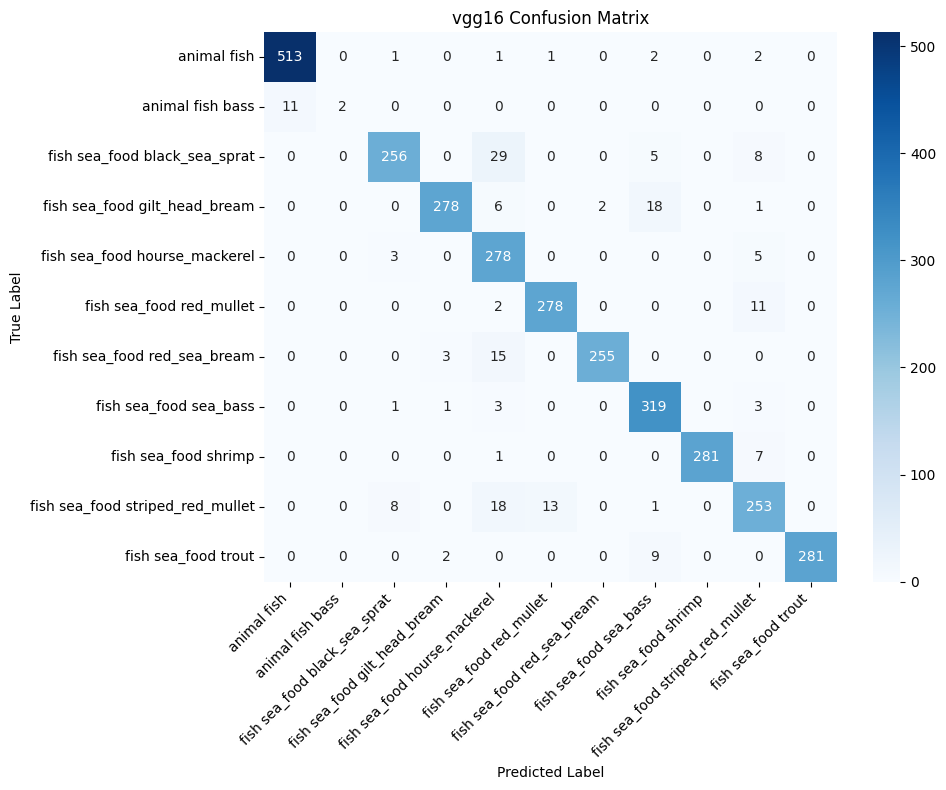

Model saved to models/vgg16_model.pkl

==================== Training resnet152 ====================


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to C:\Users\pc/.cache\torch\hub\checkpoints\resnet152-f82ba261.pth
100.0%


Epoch 1/15
----------
train Loss: 1.3423 Acc: 0.6520
val Loss: 0.7799 Acc: 0.9212

Epoch 2/15
----------
train Loss: 0.7561 Acc: 0.8141
val Loss: 0.5165 Acc: 0.9313

Epoch 3/15
----------
train Loss: 0.6127 Acc: 0.8424
val Loss: 0.3675 Acc: 0.9588

Epoch 4/15
----------
train Loss: 0.5474 Acc: 0.8559
val Loss: 0.3568 Acc: 0.9496

Epoch 5/15
----------
train Loss: 0.4812 Acc: 0.8737
val Loss: 0.2875 Acc: 0.9679

Epoch 6/15
----------
train Loss: 0.4480 Acc: 0.8747
val Loss: 0.2770 Acc: 0.9579

Epoch 7/15
----------
train Loss: 0.4105 Acc: 0.8850
val Loss: 0.2729 Acc: 0.9524

Epoch 8/15
----------
train Loss: 0.4103 Acc: 0.8811
val Loss: 0.2537 Acc: 0.9643

Epoch 9/15
----------
train Loss: 0.3908 Acc: 0.8826
val Loss: 0.2179 Acc: 0.9689

Epoch 10/15
----------
train Loss: 0.3605 Acc: 0.8991
val Loss: 0.2150 Acc: 0.9689

Epoch 11/15
----------
train Loss: 0.3543 Acc: 0.8925
val Loss: 0.2532 Acc: 0.9661
EarlyStopping counter: 1 out of 5

Epoch 12/15
----------
train Loss: 0.3566 Acc: 0.89

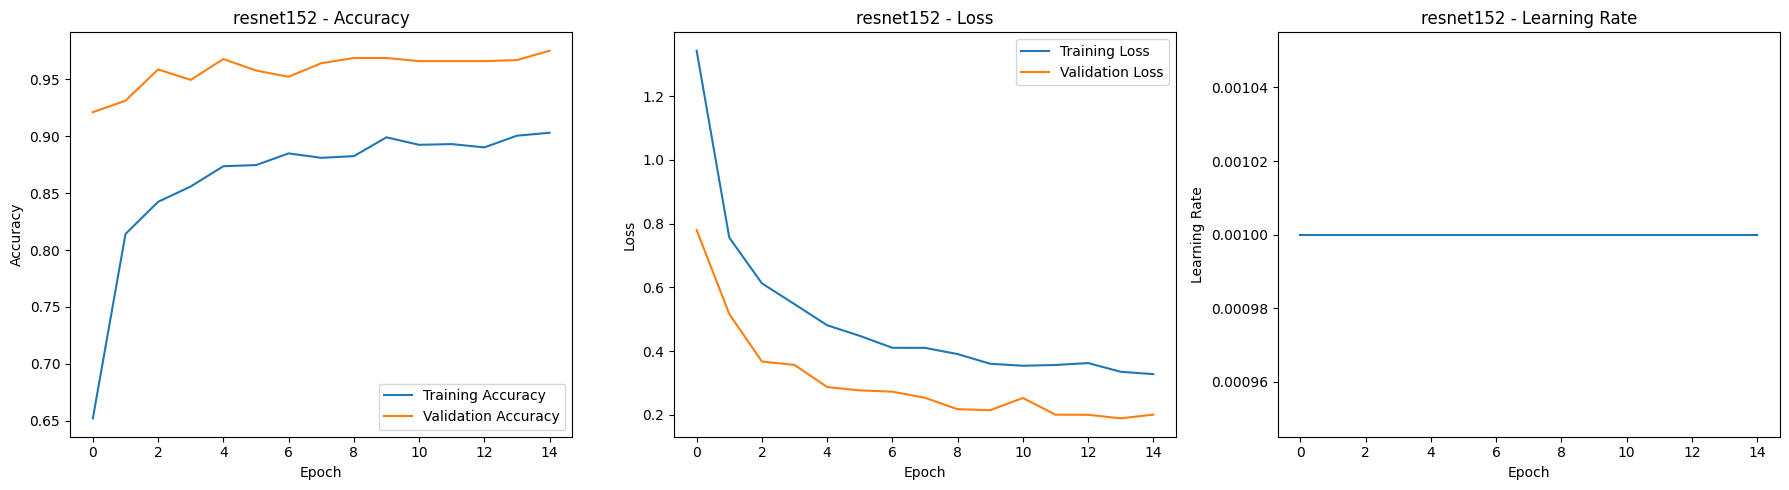

Test Loss: 0.1242 Acc: 0.9821

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      0.99      0.99       520
                animal fish bass       0.64      0.69      0.67        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      0.89      0.94       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       0.93      1.00      0.96       273
          fish sea_food sea_bass       0.98      0.98      0.98       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       0.99      0.99      0.99       293
             fish sea_food trout       0.95      1.00      0.97       292

                        accuracy                        

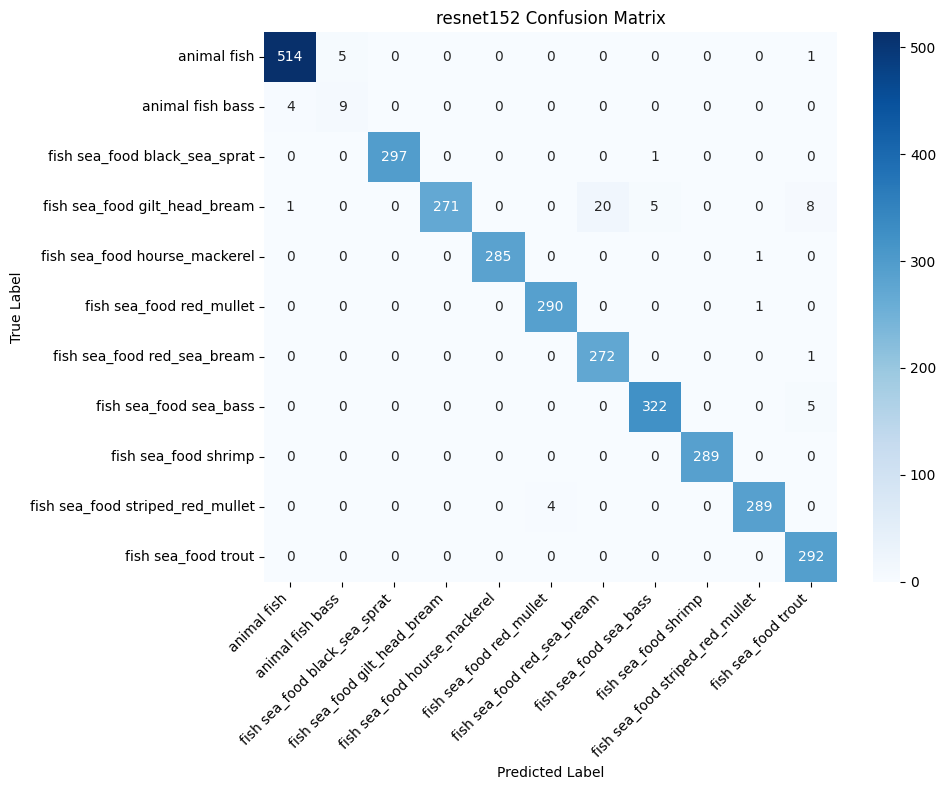

Model saved to models/resnet152_model.pkl

==================== Training convnext ====================
Epoch 1/15
----------
train Loss: 0.4675 Acc: 0.8716
val Loss: 0.1105 Acc: 0.9753

Epoch 2/15
----------
train Loss: 0.2073 Acc: 0.9409
val Loss: 0.0713 Acc: 0.9872

Epoch 3/15
----------
train Loss: 0.1575 Acc: 0.9542
val Loss: 0.0542 Acc: 0.9881

Epoch 4/15
----------
train Loss: 0.1394 Acc: 0.9584
val Loss: 0.0491 Acc: 0.9899

Epoch 5/15
----------
train Loss: 0.1331 Acc: 0.9594
val Loss: 0.0415 Acc: 0.9936

Epoch 6/15
----------
train Loss: 0.1272 Acc: 0.9619
val Loss: 0.0495 Acc: 0.9899
EarlyStopping counter: 1 out of 5

Epoch 7/15
----------
train Loss: 0.1290 Acc: 0.9618
val Loss: 0.0365 Acc: 0.9918

Epoch 8/15
----------
train Loss: 0.1106 Acc: 0.9653
val Loss: 0.0475 Acc: 0.9853
EarlyStopping counter: 1 out of 5

Epoch 9/15
----------
train Loss: 0.1061 Acc: 0.9645
val Loss: 0.0250 Acc: 0.9927

Epoch 10/15
----------
train Loss: 0.1008 Acc: 0.9679
val Loss: 0.0270 Acc: 0.9936

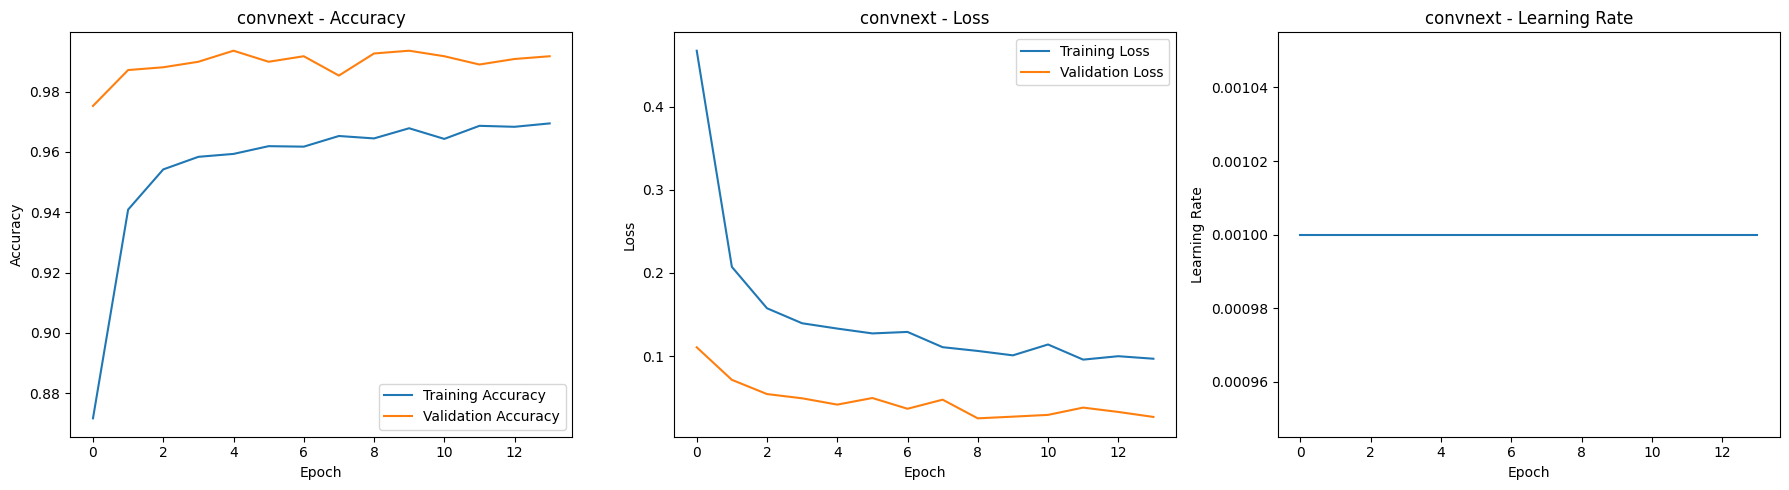

Test Loss: 0.0407 Acc: 0.9887

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       1.00      0.94      0.97       520
                animal fish bass       0.79      0.85      0.81        13
   fish sea_food black_sea_sprat       0.98      1.00      0.99       298
   fish sea_food gilt_head_bream       0.99      0.99      0.99       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       0.99      1.00      0.99       291
     fish sea_food red_sea_bream       0.99      1.00      1.00       273
          fish sea_food sea_bass       0.98      1.00      0.99       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       0.97      1.00      0.99       292

                        accuracy                        

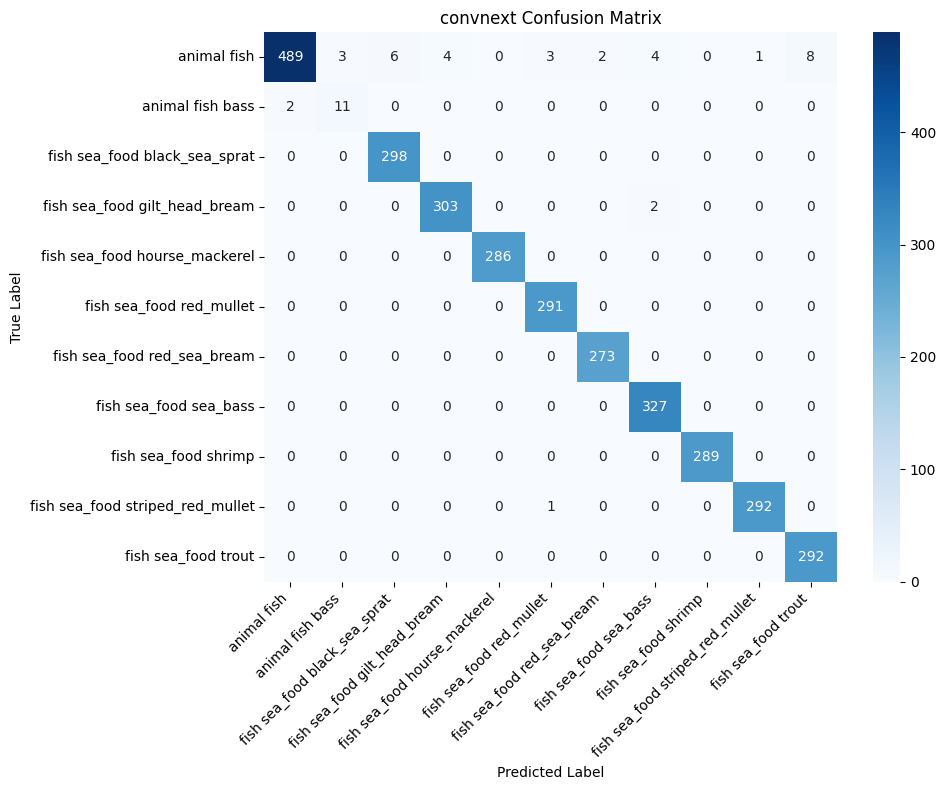

Model saved to models/convnext_model.pkl

==================== Training efficientnetv2 ====================


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to C:\Users\pc/.cache\torch\hub\checkpoints\efficientnet_v2_s-dd5fe13b.pth
100.0%


Epoch 1/15
----------
train Loss: 1.3289 Acc: 0.6559
val Loss: 0.6257 Acc: 0.8855

Epoch 2/15
----------
train Loss: 0.7937 Acc: 0.7812
val Loss: 0.4300 Acc: 0.9084

Epoch 3/15
----------
train Loss: 0.6960 Acc: 0.7892
val Loss: 0.3550 Acc: 0.9176

Epoch 4/15
----------
train Loss: 0.6232 Acc: 0.8034
val Loss: 0.3027 Acc: 0.9249

Epoch 5/15
----------
train Loss: 0.5972 Acc: 0.8093
val Loss: 0.2776 Acc: 0.9176

Epoch 6/15
----------
train Loss: 0.5897 Acc: 0.8133
val Loss: 0.2712 Acc: 0.9203

Epoch 7/15
----------
train Loss: 0.5701 Acc: 0.8132
val Loss: 0.2480 Acc: 0.9350

Epoch 8/15
----------
train Loss: 0.5591 Acc: 0.8141
val Loss: 0.2318 Acc: 0.9313

Epoch 9/15
----------
train Loss: 0.5565 Acc: 0.8162
val Loss: 0.2028 Acc: 0.9515

Epoch 10/15
----------
train Loss: 0.5322 Acc: 0.8276
val Loss: 0.2111 Acc: 0.9478
EarlyStopping counter: 1 out of 5

Epoch 11/15
----------
train Loss: 0.5392 Acc: 0.8225
val Loss: 0.2159 Acc: 0.9368
EarlyStopping counter: 2 out of 5

Epoch 12/15
-----

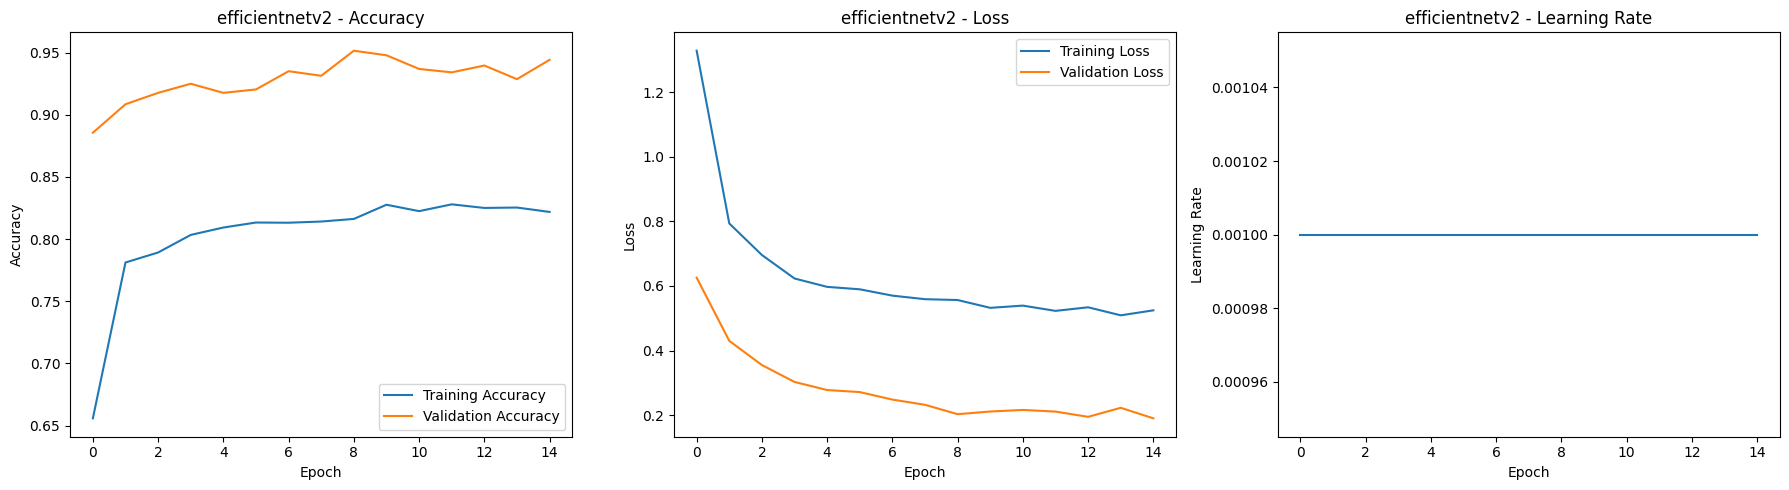

Test Loss: 0.2069 Acc: 0.9492

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.97      0.97      0.97       520
                animal fish bass       0.60      0.46      0.52        13
   fish sea_food black_sea_sprat       0.96      0.96      0.96       298
   fish sea_food gilt_head_bream       0.98      0.79      0.87       305
   fish sea_food hourse_mackerel       0.92      0.99      0.95       286
        fish sea_food red_mullet       0.97      0.97      0.97       291
     fish sea_food red_sea_bream       0.92      0.97      0.94       273
          fish sea_food sea_bass       0.93      0.96      0.95       327
            fish sea_food shrimp       0.99      0.99      0.99       289
fish sea_food striped_red_mullet       0.94      0.92      0.93       293
             fish sea_food trout       0.92      1.00      0.95       292

                        accuracy                        

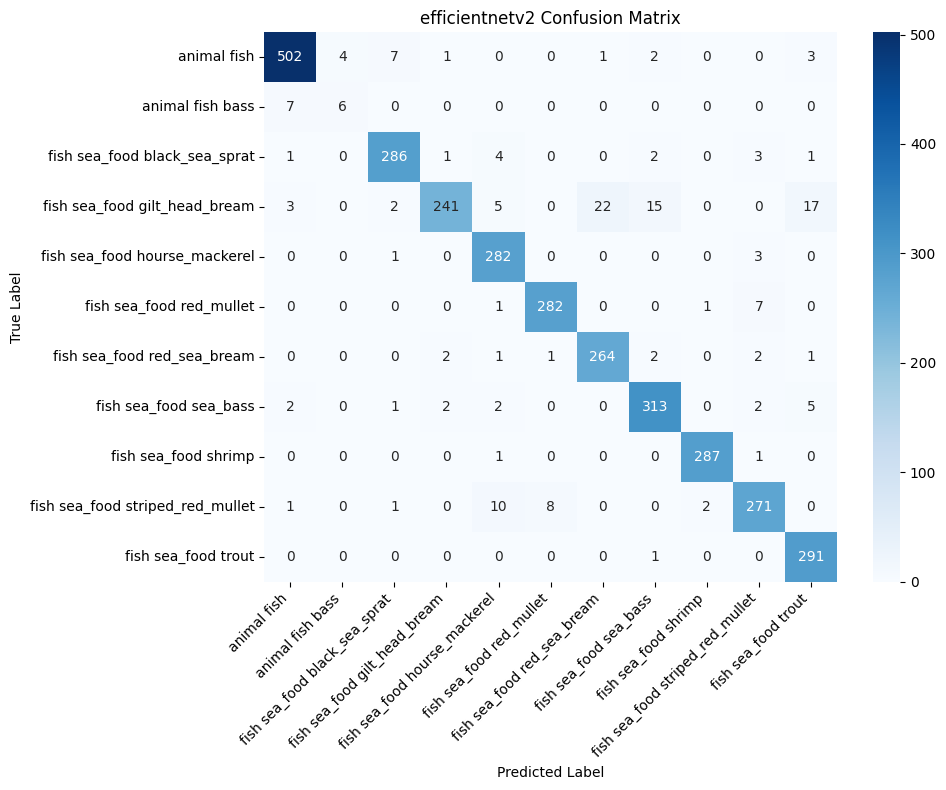

Model saved to models/efficientnetv2_model.pkl

==================== Training vit ====================
Epoch 1/15
----------
train Loss: 0.6151 Acc: 0.8218
val Loss: 0.1567 Acc: 0.9542

Epoch 2/15
----------
train Loss: 0.2934 Acc: 0.9182
val Loss: 0.0853 Acc: 0.9799

Epoch 3/15
----------
train Loss: 0.2429 Acc: 0.9261
val Loss: 0.0543 Acc: 0.9863

Epoch 4/15
----------
train Loss: 0.2143 Acc: 0.9345
val Loss: 0.0533 Acc: 0.9844

Epoch 5/15
----------
train Loss: 0.1960 Acc: 0.9398
val Loss: 0.0483 Acc: 0.9872

Epoch 6/15
----------
train Loss: 0.1876 Acc: 0.9407
val Loss: 0.0397 Acc: 0.9918

Epoch 7/15
----------
train Loss: 0.1833 Acc: 0.9425
val Loss: 0.0461 Acc: 0.9863
EarlyStopping counter: 1 out of 5

Epoch 8/15
----------
train Loss: 0.1859 Acc: 0.9433
val Loss: 0.0458 Acc: 0.9863
EarlyStopping counter: 2 out of 5

Epoch 9/15
----------
train Loss: 0.1657 Acc: 0.9459
val Loss: 0.0295 Acc: 0.9908

Epoch 10/15
----------
train Loss: 0.1618 Acc: 0.9465
val Loss: 0.0311 Acc: 0.9881

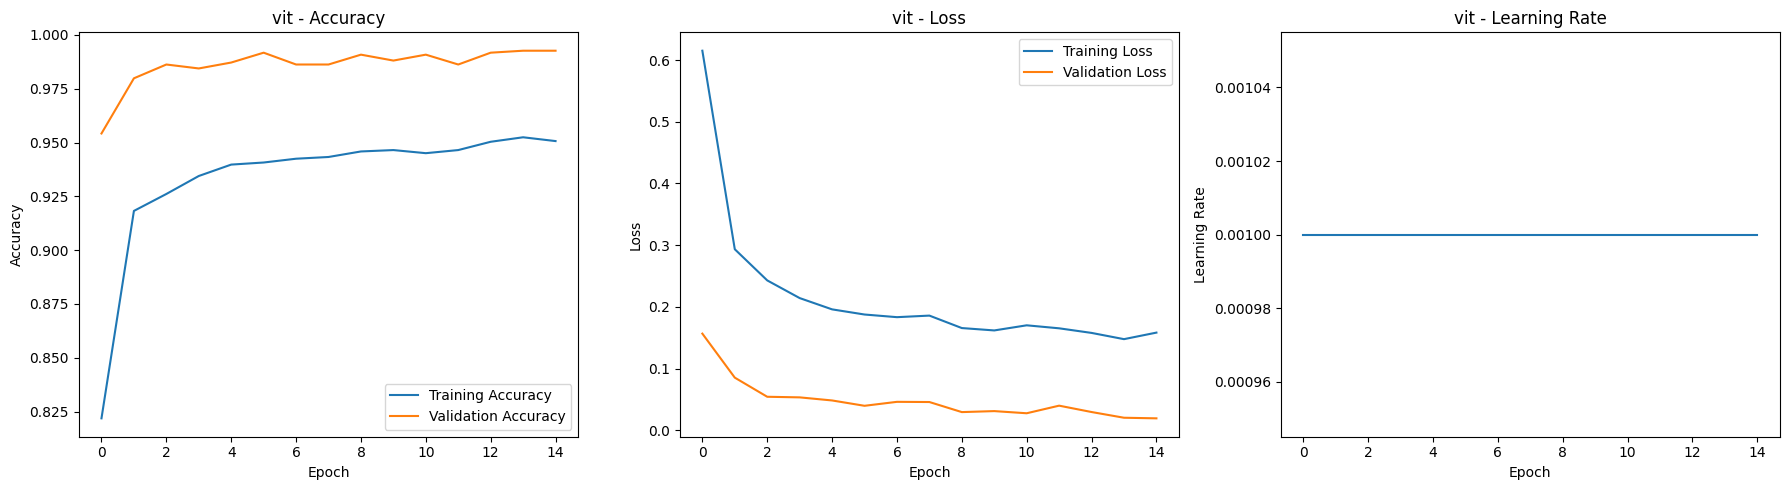

Test Loss: 0.0208 Acc: 0.9937

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      0.97      0.98       520
                animal fish bass       0.60      0.69      0.64        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       0.98      1.00      0.99       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       0.99      1.00      1.00       292

                        accuracy                        

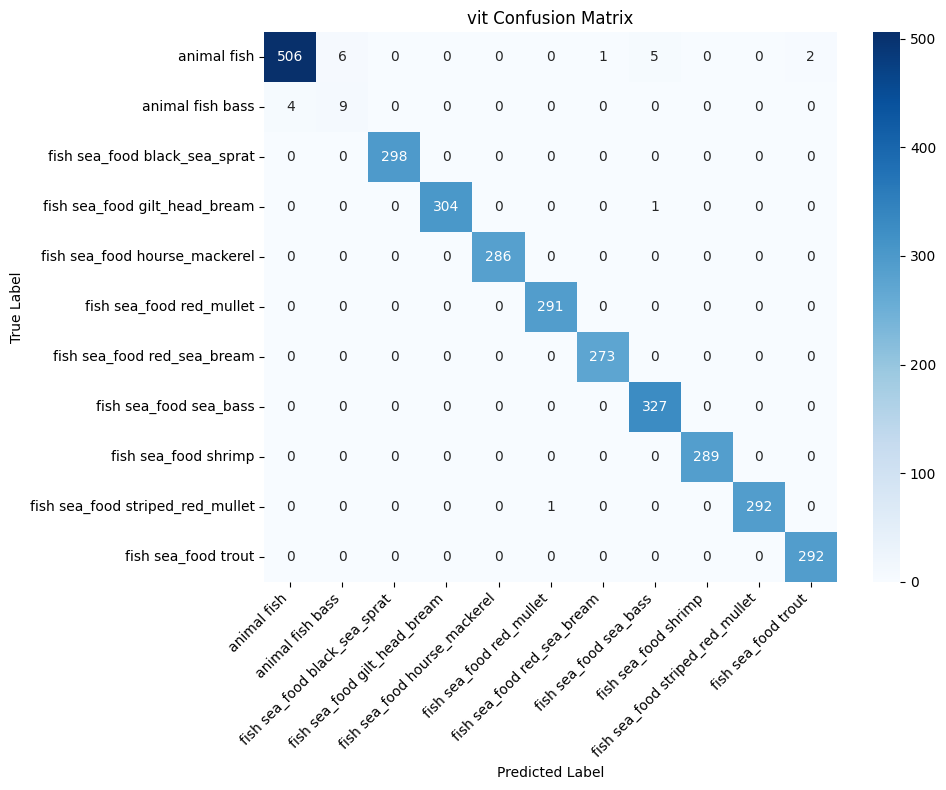

Model saved to models/vit_model.pkl


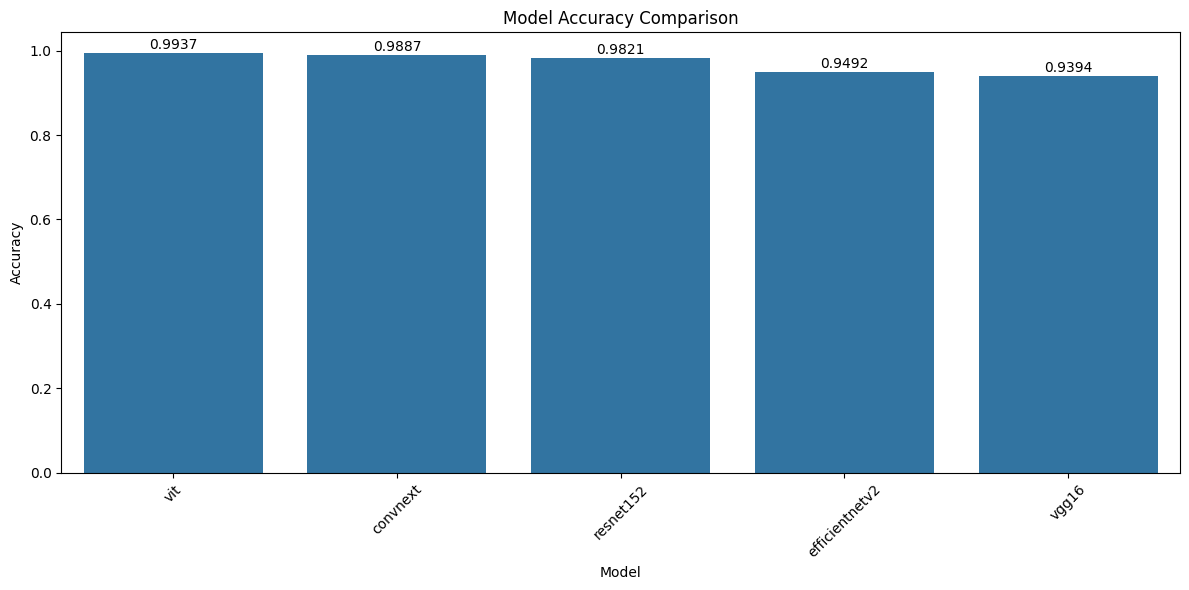


Model Performance Comparison:
            Model  Accuracy
4             vit  0.993725
2        convnext  0.988704
1       resnet152  0.982115
3  efficientnetv2  0.949168
0           vgg16  0.939441

{'='*20} Creating Ensemble {'='*20}

Evaluating ensemble with voting method...
Ensemble Accuracy (voting): 0.9975

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      0.99      0.99       520
                animal fish bass       0.82      0.69      0.75        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00      

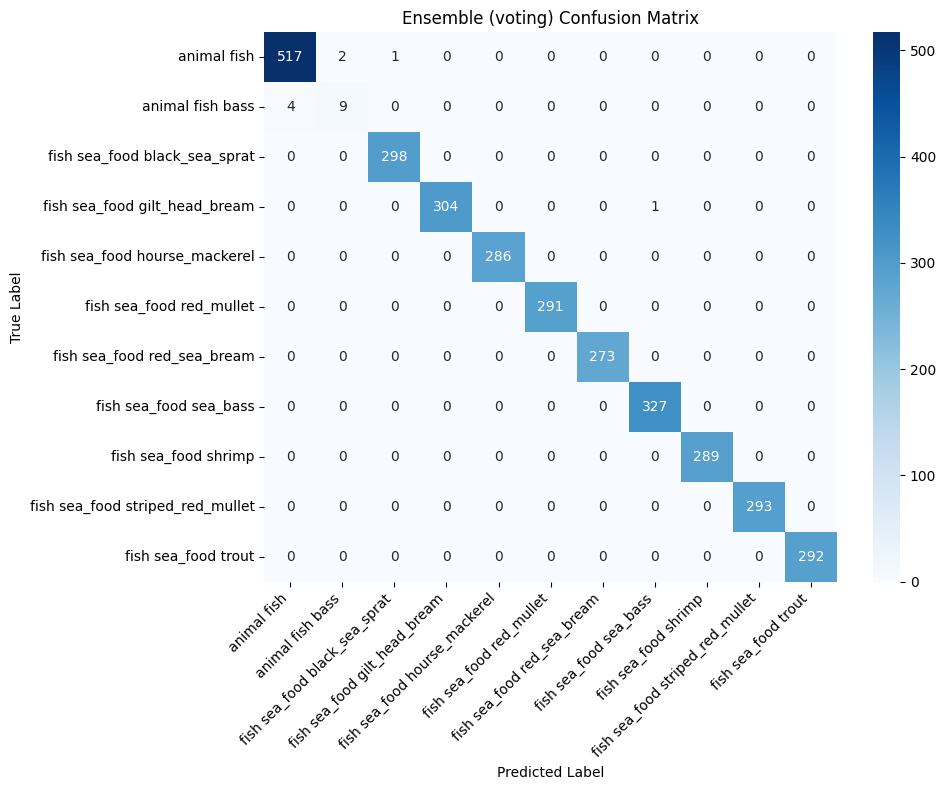


Evaluating ensemble with averaging method...
Ensemble Accuracy (averaging): 0.9984

Classification Report:
                                  precision    recall  f1-score   support

                     animal fish       0.99      1.00      1.00       520
                animal fish bass       0.90      0.69      0.78        13
   fish sea_food black_sea_sprat       1.00      1.00      1.00       298
   fish sea_food gilt_head_bream       1.00      1.00      1.00       305
   fish sea_food hourse_mackerel       1.00      1.00      1.00       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       1.00      1.00      1.00       273
          fish sea_food sea_bass       1.00      1.00      1.00       327
            fish sea_food shrimp       1.00      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      1.00      1.00       293
             fish sea_food trout       1.00      1.00      1.00       292

  

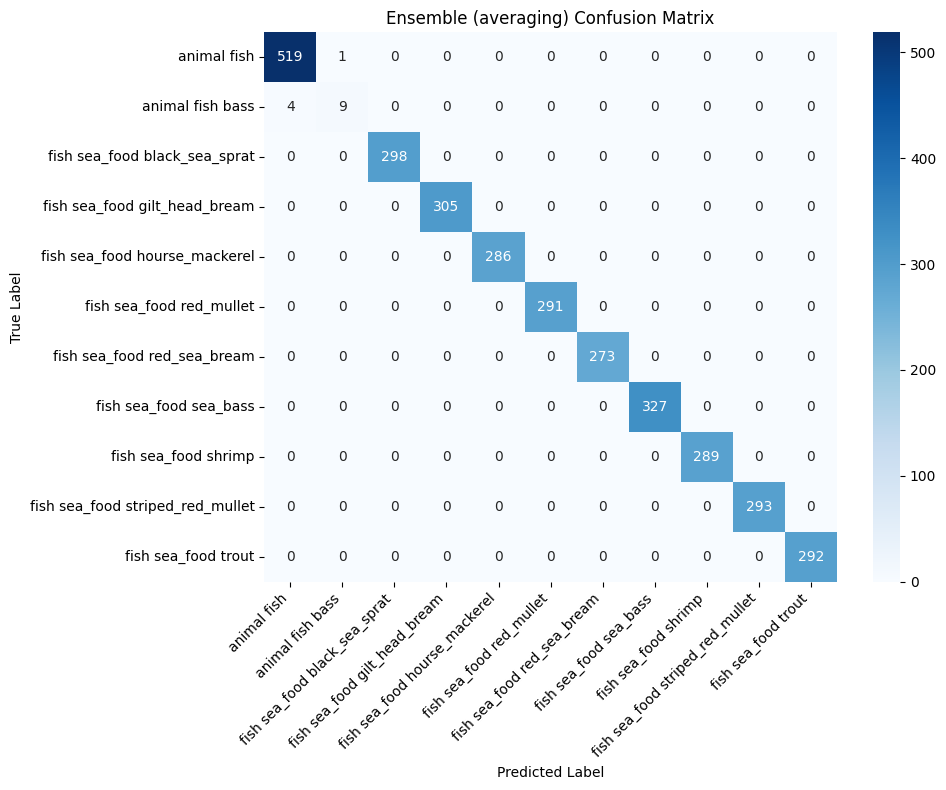


Final Results:
vgg16: Accuracy = 0.9394
resnet152: Accuracy = 0.9821
convnext: Accuracy = 0.9887
efficientnetv2: Accuracy = 0.9492
vit: Accuracy = 0.9937
Ensemble (voting): Accuracy = 0.9975
Ensemble (averaging): Accuracy = 0.9984


In [28]:
# Complete Transfer Learning Pipeline
import torch
import torch.nn as nn
import torch.optim as optim

def train_and_evaluate_models(data_loaders, models_to_train, device, num_epochs=15, use_amp=True, feature_extract=True):
    """
    Train and evaluate multiple models and create ensemble
    
    Args:
        data_loaders: Dictionary with data loaders and class info
        models_to_train: List of model names to train
        device: Device for computation
        num_epochs: Number of epochs for training
        use_amp: Whether to use mixed precision
        feature_extract: Whether to freeze pre-trained layers
        
    Returns:
        dict: Results for all models and ensemble
    """
    criterion = nn.CrossEntropyLoss()
    results = {}
    trained_models = []
    
    # Train each model
    for model_name in models_to_train:
        print(f"\n{'='*20} Training {model_name} {'='*20}")
        
        # Get model
        model = get_model(model_name, data_loaders['num_classes'], feature_extract)
        model = model.to(device)
        
        # Setup optimizer
        if feature_extract:
            params_to_update = [p for p in model.parameters() if p.requires_grad]
        else:
            params_to_update = model.parameters()
            
        optimizer = optim.Adam(params_to_update, lr=0.001)
        
        # Train model
        model, history = train_model_with_scheduler(
            model=model,
            dataloaders={
                'train': data_loaders['train_loader'],
                'val': data_loaders['val_loader']
            },
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            model_name=model_name,
            num_epochs=num_epochs,
            use_amp=use_amp
        )
        
        # Plot training history
        plot_training_history(history, model_name)
        
        # Evaluate model
        metrics = evaluate_model(
            model=model,
            dataloader=data_loaders['test_loader'],
            criterion=criterion,
            device=device,
            class_names=data_loaders['class_names']
        )
        
        # Plot confusion matrix
        plot_confusion_matrix(
            cm=metrics['confusion_matrix'],
            class_names=data_loaders['class_names'],
            title=f"{model_name} Confusion Matrix"
        )
        
        # Save model
        save_model_pkl(
            model=model,
            model_name=model_name,
            optimizer=optimizer,
            class_names=data_loaders['class_names'],
            history=history,
            metrics=metrics
        )
        
        # Store results
        results[model_name] = {
            'model': model,
            'history': history,
            'metrics': metrics
        }
        
        # Add to trained models list for ensemble
        trained_models.append(model)
    
    # Compare model performance
    comparison_df = plot_model_comparison(results)
    print("\nModel Performance Comparison:")
    print(comparison_df)
    
    # Create ensemble
    if len(trained_models) > 1:
        print("\n{'='*20} Creating Ensemble {'='*20}")
        ensemble_results = evaluate_ensemble(
            models=trained_models,
            dataloader=data_loaders['test_loader'],
            device=device,
            class_names=data_loaders['class_names']
        )
        
        results['ensemble'] = ensemble_results
    
    return results

# Main execution
def main():
    # Set device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Get data loaders
    data_dir = "E:/vscode/Fish Classification Project/images.cv_jzk6llhf18tm3k0kyttxz/data"
    data_loaders = get_enhanced_data_loaders(data_dir, batch_size=32)
    
    # Define models to train    
    models_to_train = ["vgg16", "resnet152", "convnext", "efficientnetv2", "vit"]
    
    # Train and evaluate models
    results = train_and_evaluate_models(
        data_loaders=data_loaders,
        models_to_train=models_to_train,
        device=device,
        num_epochs=15,
        use_amp=True,
        feature_extract=True
    )
    
    # Print final results
    print("\nFinal Results:")
    for model_name, result in results.items():
        if model_name != 'ensemble':
            print(f"{model_name}: Accuracy = {result['metrics']['accuracy']:.4f}")
        else:
            for method, method_result in result.items():
                print(f"Ensemble ({method}): Accuracy = {method_result['accuracy']:.4f}")
    
    return results

# Call main function when executing this notebook cell
if __name__ == "__main__":
    results = main()

In [30]:
def save_ensemble_without_evaluation(model_names):
    """
    Load previously trained models and save them as an ensemble without evaluation
    
    Args:
        model_names: List of model names to include in the ensemble
        
    Returns:
        str: Path to saved ensemble model
    """
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Load all trained models
    trained_models = []
    class_names = None
    
    for model_name in model_names:
        # Load model from pickle file
        model_path = f"models/{model_name}_model.pkl"
        try:
            checkpoint = load_model_pkl(model_path)
            model = checkpoint['model']
            trained_models.append(model)
            
            # Get class names from the first model
            if class_names is None:
                class_names = checkpoint['class_names']
                
            print(f"Loaded {model_name} model successfully")
        except Exception as e:
            print(f"Error loading {model_name} model: {e}")
    
    if len(trained_models) < 2:
        print("Need at least 2 models to create an ensemble")
        return None
    
    # Create file path
    file_path = f"models/ensemble_model.pkl"
    
    # Save ensemble information
    with open(file_path, 'wb') as f:
        pickle.dump({
            'models': trained_models,
            'class_names': class_names,
            'num_classes': len(class_names),
            'methods': ['voting', 'averaging']  # Default methods
        }, f)
    
    print(f"Ensemble model saved to {file_path}")
    return file_path

# Example usage:
def main_save_ensemble():
    # Define models to include in ensemble
    model_names = ["vgg16", "resnet152", "convnext", "efficientnetv2", "vit"]
    
    # Create and save ensemble
    ensemble_path = save_ensemble_without_evaluation(model_names)
    
    print(f"Ensemble saved to: {ensemble_path}")

# Run this function to create the ensemble
if __name__ == "__main__":
    main_save_ensemble()

Model loaded from models/vgg16_model.pkl
Loaded vgg16 model successfully
Model loaded from models/resnet152_model.pkl
Loaded resnet152 model successfully
Model loaded from models/convnext_model.pkl
Loaded convnext model successfully
Model loaded from models/efficientnetv2_model.pkl
Loaded efficientnetv2 model successfully
Model loaded from models/vit_model.pkl
Loaded vit model successfully
Ensemble model saved to models/ensemble_model.pkl
Ensemble saved to: models/ensemble_model.pkl
